# Stacking [(ARIMAX + RNN) --> LR]

In [1]:
# 1. Import libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import acf, pacf
from numpy import array
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression
import keras
keras.utils.set_random_seed(47)

In [2]:
#2. Import dataset
data = pd.read_csv("D:\Đồ án PTDLKD\Data_stock_SCS_VN.csv")
data

,time,open,high,low,close,volume
0,2019-03-01,59960,59960,59920,59960,34010
1,2019-03-04,59960,60080,58980,59960,8580
2,2019-03-05,58720,60010,58720,59960,35720
3,2019-03-06,59960,60130,59960,59960,9290
4,2019-03-07,59960,60400,59960,60330,19290
...,...,...,...,...,...,...
1248,2024-02-23,75000,75400,73600,73800,91600
1249,2024-02-26,74000,75500,73800,75400,95900
1250,2024-02-27,75400,76000,74000,74700,39400
1251,2024-02-28,74500,75700,74500,75500,63500


# ARIMAX

In [3]:
#3. Partition the data into necessary segments
split = int(len(data)*0.9)

x_train_a = data[:split].index
y_train_a = data[:split][['close']]
exg_train_a = data[:split][['high','low']]

x_test_a = data[split:].index
y_test_a = data[split:][['close']]
exg_test_a = data[split:][['high','low']]

In [4]:
#4. Function for adf testing
def adf_test(dataset):
    dftest =  adfuller (dataset, autolag='AIC') 
    print("1. ADF: ",dftest[0])
    print("2. P-Value: ", round (dftest[1],6))
    print("3. Num Of Lags: ", dftest[2])
    print("4. Critical Values :")
    for key, val in dftest [4].items():
        print("\t",key, ":", val)
    if (dftest[0] < dftest [4]["5%"] or dftest[0] < dftest[4]["1%"] or dftest[0] < dftest[4]["10%"]): 
        print ("Reject H0: Time Series is Stationary")
        return True
    else:
        print ("Failed to Reject H0: Time Series is Non-Stationary") 
        return False

In [5]:
#5. Check the stationarity of the data and determine d
diff_order = 0
is_stationary = False
while not is_stationary:
    if diff_order > 0:
        train_diff = pd.DataFrame(np.diff(y_train_a['close'], diff_order))
        train_diff.index = y_train_a.index[diff_order:]
        train_diff.columns = ['close']
        diff = train_diff
    else:
        diff = y_train_a

    print('-' * 50)
    print('Difference order:', diff_order) 
    if adf_test(diff['close']):
        is_stationary =  True
    else:
        diff_order += 1
print('-' * 50)
print('Choose d =', diff_order)

--------------------------------------------------
Difference order: 0
1. ADF:  -1.8119791833439858
2. P-Value:  0.374531
3. Num Of Lags:  0
4. Critical Values :
	 1% : -3.4361708439503587
	 5% : -2.86411024137968
	 10% : -2.5681384677365924
Failed to Reject H0: Time Series is Non-Stationary
--------------------------------------------------
Difference order: 1
1. ADF:  -25.166164660463085
2. P-Value:  0.0
3. Num Of Lags:  1
4. Critical Values :
	 1% : -3.4361812251221555
	 5% : -2.864114820815637
	 10% : -2.5681409066817795
Reject H0: Time Series is Stationary
--------------------------------------------------
Choose d = 1


Text(0.5, 1.0, 'PACF')

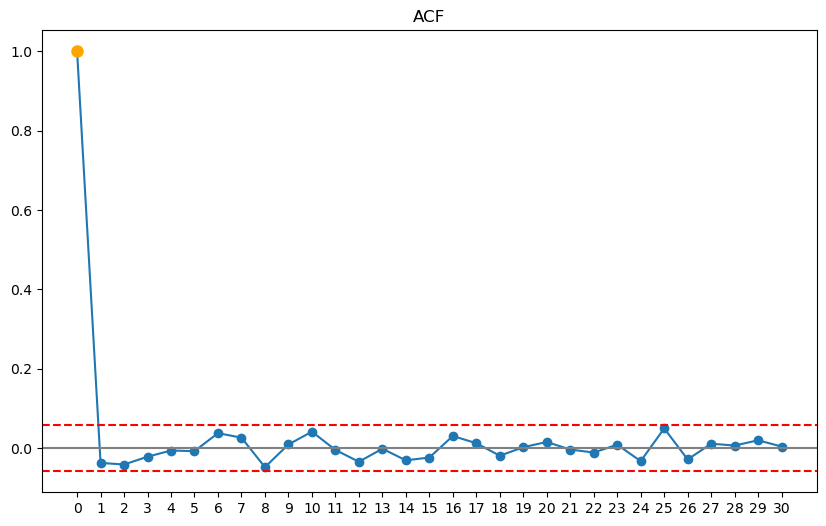

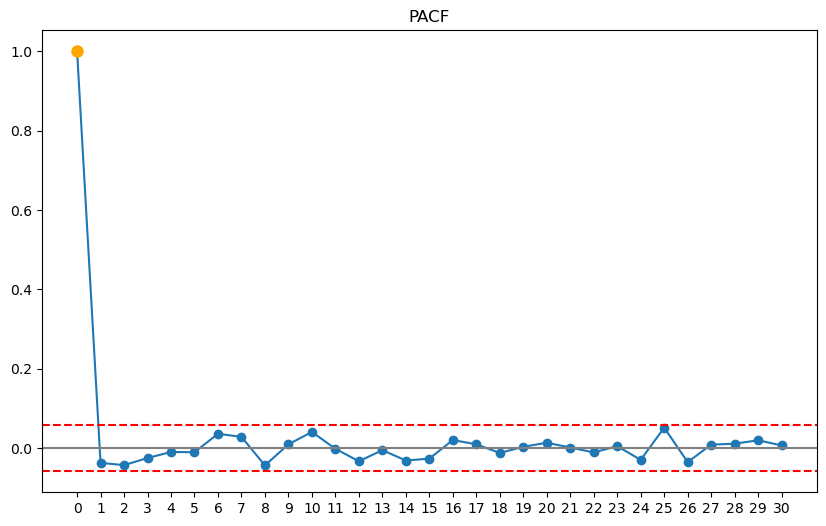

In [6]:
#6. From ACF and PACF, we determine the lists of p and q
acf_plot= acf(diff['close'])
pacf_plot= pacf(diff['close'])
limit_sig = (math.exp(2 * 1.96 / math.sqrt(len(diff['close']) - 3))-1) / (math.exp(2 * 1.96 / math.sqrt(len(diff['close']) - 3)) + 1)
list_q=[]
list_p=[]

# Plot ACF
plt.figure(figsize=(10, 6))
N = len(diff['close'])  
plt.plot(acf_plot, marker='o', linestyle='-') 
plt.axhline(y=0, color="gray")
plt.axhline(y=limit_sig, color='red', linestyle='--') 
plt.axhline(y=-limit_sig, color='red', linestyle='--')
plt.xticks(np.arange(0, 31, step=1))
for i, val in enumerate(acf_plot):
    if val > limit_sig:
        plt.plot(i, val, marker='o', markersize=8, color='orange', linestyle='None')
        list_q.append(i)
    if val < -limit_sig:
        plt.plot(i, val, marker='o', markersize=8, color='orange', linestyle='None')
        list_q.append(i)
plt.title('ACF')

# Plot PACF
plt.figure(figsize=(10, 6))
plt.plot(pacf_plot, marker='o', linestyle='-') 
plt.axhline(y=0, color="gray")
plt.axhline(y=limit_sig, color='red', linestyle='--') 
plt.axhline(y=-limit_sig, color='red', linestyle='--')
plt.xticks(np.arange(0, 31, step=1))
for i, val in enumerate(pacf_plot):
    if val > limit_sig:
        plt.plot(i, val, marker='o', markersize=8, color='orange', linestyle='None')
        list_p.append(i)
    if val < -limit_sig:
        plt.plot(i, val, marker='o', markersize=8, color='orange', linestyle='None')
        list_p.append(i)
plt.title('PACF')

In [7]:
#7. Train the model with the lists of p and q obtained from PACF and ACF
aic_values = []
model_params = []
for q_value in list_q:
    for p_value in list_p:
        model_arimax = ARIMA(y_train_a, exog=exg_train_a, order=(p_value, diff_order, q_value)).fit()
        aic_values.append(model_arimax.aic)
        model_params.append((p_value, diff_order, q_value))
        
# Print models with the lowest AIC, from lowest to highest
aic_params = sorted(zip(aic_values, model_params), key=lambda x: x[0])
for i, (aic, params) in enumerate(aic_params, 1):
    print(f"Model {i}: AIC = {aic}, Parameters: p={params[0]}, d={params[1]}, q={params[2]}")


Model 1: AIC = 18059.18533368093, Parameters: p=0, d=1, q=0


In [8]:
# Specifically, in the dataset "Data_stock_SCS_VN" the only parameter pair identified is (0,1,0).
# Although these parameters all have p-values < 0.05, is this the best parameter pair for the model?
model_arimax = ARIMA(y_train_a, exog=exg_train_a, order=(0, 1, 0)).fit()
pred_test_a = model_arimax.predict(start=len(x_train_a), end=len(x_train_a) + len(x_test_a) - 1, exog=exg_test_a)
print(model_arimax.summary())
rmse = np.sqrt(mean_squared_error(y_test_a, pred_test_a))
mape = mean_absolute_percentage_error(y_test_a, pred_test_a) * 100
msle = mean_squared_log_error(y_test_a,pred_test_a)
print("\nRMSE:", rmse)
print("MAPE:", mape ,"%")
print("MSLE:", msle)

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1127
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -9026.593
Date:                Wed, 15 May 2024   AIC                          18059.185
Time:                        16:44:29   BIC                          18074.265
Sample:                             0   HQIC                         18064.883
                               - 1127                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
high           0.4748      0.013     36.696      0.000       0.449       0.500
low            0.2302      0.013     17.910      0.000       0.205       0.255
sigma2      5.377e+05   1.37e+04     39.330      0.0

In [9]:
#8. Therefore, in addition to selecting the p and d values identified by PACF and ACF,we will also take additional p and d values from 0 to 9 and put them to the list_p and list_d
combined_p = set(list_p).union(range(0, 10))
list_p = list(combined_p)
combined_q = set(list_q).union(range(0, 10))
list_q = list(combined_q)

In [10]:
#9. Train the model with the new lists of p and q
signi_models = []
best_model = []
best_rmse = float('inf')

for p_value in list_p:
    for q_value in list_q:
        try:
            model_arimax = ARIMA(y_train_a, exog=exg_train_a, order=(p_value, diff_order, q_value)).fit()
            p_values = model_arimax.pvalues
            if all(p < 0.05 for p in p_values):
                signi_models.append((p_value, q_value))
            else:
                raise Exception("Model not significant")
            pred_test_a = model_arimax.predict(start=len(x_train_a), end=len(x_train_a) + len(x_test_a) - 1, exog=exg_test_a)
            rmse = np.sqrt(mean_squared_error(y_test_a, pred_test_a))
            if rmse < best_rmse:
                best_model = (p_value, q_value)
                best_rmse = rmse
        except Exception as e:
            pass

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

In [11]:
#10. Print the list of models that have statistical significance and the model with the lowest rmse from this list
print("List model have statistical significance:")
for model_params in signi_models:
    print("- p_value:", model_params[0], ", d_value:", diff_order, ", q_value:", model_params[1])    
print("\nBest model: p=", best_model[0], ", d=", diff_order, ", q=", best_model[1])

List model have statistical significance:
- p_value: 0 , d_value: 1 , q_value: 0
- p_value: 0 , d_value: 1 , q_value: 1
- p_value: 1 , d_value: 1 , q_value: 0
- p_value: 2 , d_value: 1 , q_value: 0
- p_value: 2 , d_value: 1 , q_value: 3
- p_value: 3 , d_value: 1 , q_value: 0
- p_value: 4 , d_value: 1 , q_value: 0
- p_value: 5 , d_value: 1 , q_value: 0
- p_value: 6 , d_value: 1 , q_value: 0
- p_value: 7 , d_value: 1 , q_value: 0
- p_value: 8 , d_value: 1 , q_value: 0
- p_value: 9 , d_value: 1 , q_value: 0

Best model: p= 2 , d= 1 , q= 3


In [12]:
#11. It can be seen in the dataset "Data_stock_SCS_VN" that the new parameter set of 2,1,3 is statistically significant 
#and yields a much better RMSE,MAPE,MSLE compared to the parameter set of 0,1,0 identified from each PACF and ACF 
#RMSE,MAPE,MSLE: ARIMAX(2,1,3) 446.884 ,0.508% ,4.459e-05
#RMSE,MAPE,MSLE: ARIMAX(0,1,0) 1055.735 ,1.106% ,23.317e-05

model_arimax = ARIMA(y_train_a, exog=exg_train_a, order=(best_model[0], diff_order,best_model[1])).fit()
pred_test_a = model_arimax.predict(start=len(x_train_a), end=len(x_train_a) + len(x_test_a) - 1, exog=exg_test_a)
print(model_arimax.summary())
rmse = np.sqrt(mean_squared_error(y_test_a, pred_test_a))
mape = mean_absolute_percentage_error(y_test_a, pred_test_a) * 100
msle = mean_squared_log_error(y_test_a,pred_test_a)
print("\nRMSE:", rmse)
print("MAPE:", mape ,"%")
print("MSLE:", msle)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1127
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -8731.138
Date:                Wed, 15 May 2024   AIC                          17478.276
Time:                        16:47:38   BIC                          17518.487
Sample:                             0   HQIC                         17493.470
                               - 1127                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
high           0.6081      0.010     62.029      0.000       0.589       0.627
low            0.3845      0.011     35.564      0.000       0.363       0.406
ar.L1         -0.3520      0.065     -5.443      0.0

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# RNN

In [13]:
#12. Scaler data for RNN model
data_rnn=data.reset_index()['close']
scaler=MinMaxScaler(feature_range=(0,1))
data_rnn=scaler.fit_transform(np.array(data_rnn).reshape(-1,1))

In [14]:
#13. Split the data into train and test sets
train_size = int(0.9 * len(data_rnn))
test_size = len(data_rnn) - train_size
train_rnn = data_rnn[:train_size]
test_rnn = data_rnn[train_size:]

In [15]:
#14. Function to create a dataset for RNN model
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [16]:
#15. Reshape into X=t,t+1,t+2..t+99 [samples, time steps, features] and Y=t+100 [samples]
time_step = 100
x_train_rnn, y_train_rnn = create_dataset(train_rnn, time_step)
x_test_rnn, y_test_rnn = create_dataset(test_rnn, time_step)
x_train_rnn =x_train_rnn.reshape(x_train_rnn.shape[0],x_train_rnn.shape[1] , 1)
x_test_rnn = x_test_rnn.reshape(x_test_rnn.shape[0],x_test_rnn.shape[1] , 1)

In [17]:
#16. Proceed to define the RNN model
model_rnn = Sequential()
model_rnn.add(SimpleRNN(128, return_sequences=True, input_shape=(time_step, 1)))
model_rnn.add(Dropout(0.5))  
model_rnn.add(SimpleRNN(128))
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(1))
model_rnn.compile(loss='mean_squared_error',optimizer='adam')

C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
#17. Fit model with train data
model_rnn.fit(x_train_rnn,y_train_rnn,validation_data=(x_test_rnn,y_test_rnn),epochs=50,batch_size=32,verbose=1)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.3720 - val_loss: 0.0333
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1125 - val_loss: 0.0040
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0794 - val_loss: 0.0013
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0526 - val_loss: 0.0028
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0413 - val_loss: 0.0018
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0348 - val_loss: 0.0024
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0233 - val_loss: 0.0011
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0190 - val_loss: 7.6078e-04
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0183 - val_loss: 9.7748e-04
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0148 - val_loss: 0.0026
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0146 - val_loss: 0.0013
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - l

# Linear Regression

In [19]:
#18. Prepare train data for LR Model using predictions on train data from ARIMAX and RNN Models
pred_train_a = model_arimax.predict(start= len(x_train_a), end=len(x_train_a) * 2 -1 , exog=exg_train_a)
pred_train_rnn=model_rnn.predict(x_train_rnn)
pred_train_rnn=scaler.inverse_transform(pred_train_rnn)
df_pred_train_a = pd.DataFrame({'arima': pred_train_a[(time_step+1):]}).reset_index().drop('index', axis=1)
df_pred_train_rnn = pd.DataFrame(pred_train_rnn, columns=['rnn'])

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [20]:
#19.Fit a model with inputs being the predictions of ARIMAX models, RNN model, and two features "high" and "low"
x_train_lr = pd.concat([df_pred_train_a, df_pred_train_rnn,exg_train_a[(time_step+1):].reset_index().drop(['index'], axis=1)], axis=1)
y_train_lr = y_train_a[(time_step+1):]
model_lr= LinearRegression()
model_lr.fit(x_train_lr, y_train_lr)

LinearRegression()

In [21]:
#20. Prepare test data for LR model using predictions on test data from ARIMAX and RNN models
pred_test_a = model_arimax.predict(start=len(x_train_a), end=len(x_train_a) + len(x_test_a) - 1, exog=exg_test_a)
pred_test_rnn=model_rnn.predict(x_test_rnn)
pred_test_rnn=scaler.inverse_transform(pred_test_rnn)
df_pred_test_a = pd.DataFrame({'arima': pred_test_a[(time_step+1):]}).reset_index().drop('index', axis=1)
df_pred_test_rnn = pd.DataFrame(pred_test_rnn, columns=['rnn'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [22]:
#21. Predict on the test data 
x_test_lr = pd.concat([df_pred_test_a, df_pred_test_rnn,exg_test_a[(time_step+1):].reset_index().drop(['index'], axis=1)], axis=1)
y_test_lr = y_test_a[(time_step+1):]
pred_test_lr = model_lr.predict(x_test_lr)

In [23]:
#22. Evaluate model performance using RMSE, MAPE, and MSLE
print("ARIMAX Model")
rmse = np.sqrt(mean_squared_error(pred_test_a[(time_step+1):],y_test_lr))
mape = mean_absolute_percentage_error(pred_test_a[(time_step+1):],y_test_lr) * 100
msle = mean_squared_log_error(pred_test_a[(time_step+1):],y_test_lr)
print("RMSE:", rmse)
print("MAPE:", mape ,"%")
print("MSLE:", msle)

print("\nRNN Model")
rmse = np.sqrt(mean_squared_error(pred_test_rnn,y_test_lr))
mape = mean_absolute_percentage_error(pred_test_rnn,y_test_lr) * 100
msle = mean_squared_log_error(pred_test_rnn,y_test_lr)
print("RMSE:", rmse)
print("MAPE:", mape ,"%")
print("MSLE:", msle)

print("\nStacking Model")
rmse = np.sqrt(mean_squared_error(pred_test_lr,y_test_lr))
mape = mean_absolute_percentage_error(pred_test_lr,y_test_lr) * 100
msle = mean_squared_log_error(pred_test_lr,y_test_lr)
print("RMSE:", rmse)
print("MAPE:", mape ,"%")
print("MSLE:", msle)

ARIMAX Model
RMSE: 523.0823791896064
MAPE: 0.5530308284483474 %
MSLE: 5.462774986077042e-05

RNN Model
RMSE: 1633.9956230091877
MAPE: 1.7366505450213041 %
MSLE: 0.0005680776527343082

Stacking Model
RMSE: 503.7574124357338
MAPE: 0.5595261294347544 %
MSLE: 5.061170804275111e-05


In [24]:
#23. Function is used to predict the high and low columns for the next 30 days because the ARIMAX model requires exogenous variables
def predict_by_rnn(data_rnn):
    scaler=MinMaxScaler(feature_range=(0,1))
    data_rnn=scaler.fit_transform(np.array(data_rnn).reshape(-1,1))
    
    train_size = int(0.9 * len(data_rnn))
    test_size = len(data_rnn) - train_size
    train_rnn = data_rnn[:train_size]
    test_rnn = data_rnn[train_size:]
    
    time_step = 100
    x_train_rnn, y_train_rnn = create_dataset(train_rnn, time_step)
    x_test_rnn, y_test_rnn = create_dataset(test_rnn, time_step)
    x_train_rnn =x_train_rnn.reshape(x_train_rnn.shape[0],x_train_rnn.shape[1] , 1)
    x_test_rnn = x_test_rnn.reshape(x_test_rnn.shape[0],x_test_rnn.shape[1] , 1)
    
    model_rnn = Sequential()
    model_rnn.add(SimpleRNN(128, return_sequences=True, input_shape=(time_step, 1)))
    model_rnn.add(Dropout(0.5))  
    model_rnn.add(SimpleRNN(128))
    model_rnn.add(Dropout(0.5))
    model_rnn.add(Dense(1))
    model_rnn.compile(loss='mean_squared_error',optimizer='adam')
    model_rnn.fit(x_train_rnn,y_train_rnn,validation_data=(x_test_rnn,y_test_rnn),epochs=50,batch_size=32,verbose=1)
      
    x_input=test_rnn[-(time_step+1):].reshape(1,-1)
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()
    lst_output=[]
    n_steps=100
    i=0
    while(i<30):

        if(len(temp_input)>time_step):
            x_input=np.array(temp_input[1:])
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model_rnn.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps,1))
            yhat = model_rnn.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i=i+1
    pred30_rnn=scaler.inverse_transform(lst_output)
    
    return pred30_rnn


In [25]:
#24. Predict high and low for the next 30 days
high_pred30_rnn = predict_by_rnn(data.reset_index()['high'])
low_pred30_rnn = predict_by_rnn(data.reset_index()['low'])
    

Epoch 1/50


C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.7264 - val_loss: 0.0025
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1729 - val_loss: 0.0048
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1063 - val_loss: 0.0209
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0813 - val_loss: 0.0119
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0715 - val_loss: 0.0074
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0539 - val_loss: 9.9539e-04
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0390 - val_loss: 0.0011
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0303 - val_loss: 0.0013
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0258 - val_loss: 0.0012
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0247 - val_loss: 0.0016
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0247 - val_loss: 0.0014
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0201 - v

C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7893 - val_loss: 0.0970
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2470 - val_loss: 0.0273
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1217 - val_loss: 0.0092
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0943 - val_loss: 0.0126
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0696 - val_loss: 0.0026
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0502 - val_loss: 0.0078
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0399 - val_loss: 0.0033
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0313 - val_loss: 0.0016
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0302 - val_loss: 6.9888e-04
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0263 - val_loss: 0.0015
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0217 - val_loss: 0.0019
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0213 - v

In [26]:
#25. Predict close for the next 30 days by ARIMAX model
df_high_pred30_rnn = pd.DataFrame(high_pred30_rnn, columns=['high'])
df_low_pred30_rnn = pd.DataFrame(low_pred30_rnn, columns=['low'])
exg_pred30_a = pd.concat([df_high_pred30_rnn, df_low_pred30_rnn], axis=1)
close_pred30_a = model_arimax.predict(start=len(x_train_a), end=len(x_train_a) + 29, exog=exg_pred30_a)

In [27]:
#26. Predict close for the next 30 days by RNN model
x_input=test_rnn[-(time_step+1):].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
lst_output=[]
n_steps=100
i=0
while(i<30):
    if(len(temp_input)>time_step):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model_rnn.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model_rnn.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
close_pred30_rnn=scaler.inverse_transform(lst_output)

In [28]:
#27. Predict close for the next 30 days by Stacking model [(ARIMAX + RNN) --> LR]
df_close_pred30_a  = pd.DataFrame({'arima': close_pred30_a}).reset_index().drop('index', axis=1)
df_close_pred30_rnn  = pd.DataFrame(close_pred30_rnn, columns=['rnn'])
x_pred30_lr = pd.concat([df_close_pred30_a,df_close_pred30_rnn,df_high_pred30_rnn,df_low_pred30_rnn], axis=1)
close_pred30_stacking = model_lr.predict(x_pred30_lr)

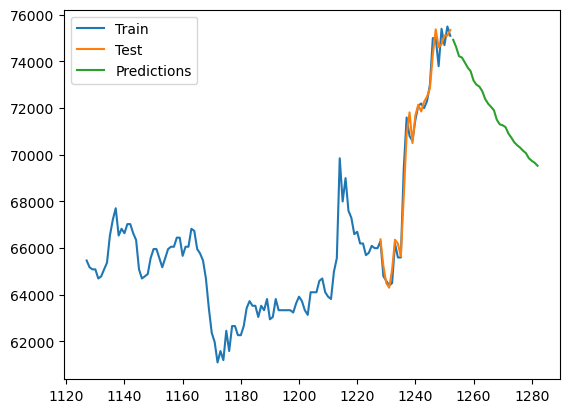

In [30]:
#28. Draw the plot 
test_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_index,y_test_a)
pred_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(pred_index,pred_test_lr)
pred30_index = pd.RangeIndex(start=len(data), stop=len(data)+30, step=1)
plt.plot(pred30_index,close_pred30_stacking)
plt.legend(["Train","Test","Predictions","Next 30 days"])
plt.show()